<a href="https://colab.research.google.com/github/khaloodi/DS-Unit-2-Classification-2/blob/master/DS_Sprint_Challenge_9_Classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Classification 2 Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

In [0]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [0]:
y_train = train['Fail']
y_train.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

### Majority Baseline

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_train, fill_value=majority_class)
accuracy_score(y_train, y_pred)

0.741389937591494

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

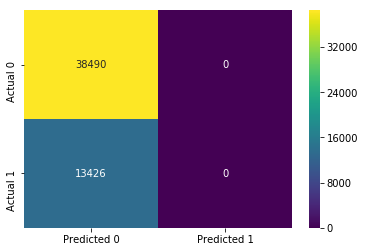

In [0]:
plot_confusion_matrix(y_train, y_pred);

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85     38490
           1       0.00      0.00      0.00     13426

    accuracy                           0.74     51916
   macro avg       0.37      0.50      0.43     51916
weighted avg       0.55      0.74      0.63     51916



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
y_pred_proba = np.full_like(y_train, fill_value=1.00)
roc_auc_score(y_train, y_pred_proba)

0.5

In [0]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [0]:
def wrangle(X):
    X = X.copy()
    drop = ['Inspection ID', 'AKA Name', 'License #', 'Violations', 'Location', 'Fail']
    X = X.drop(columns=drop)
    many_nulls = ['Facility Type', 'Risk', 'City', 'State', 'Zip', 'Inspection Type', 'Latitude', 'Longitude']
    for col in many_nulls:
        X[col] = X[col].isnull()
    return X

X_train = wrangle(train)
X_test = wrangle(test)

In [0]:
train.Risk.value_counts(normalize=True)

Risk 1 (High)      0.726938
Risk 2 (Medium)    0.195284
Risk 3 (Low)       0.077778
Name: Risk, dtype: float64

In [0]:
!pip install category_encoders

In [0]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ce.OrdinalEncoder(), RandomForestClassifier())
#make a list inside pipeline of what we want pipeline to do

In [0]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA Name', 'Address', 'Inspection Date'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA Name',
                                          'data_type': dtype('O'),
                                          'mapping': TOM YUM RICE & NOODLE, INC.                       1
FILLING STATION  & CONVENIENCE  STORE             2
A P DELI                                          3
FRANK'S CHICAGO SHRIMP HOUSE                      4
MORRILL                                           5
LAKEVIEW REHABILITATION A...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf

### Predictions With Leakage

In [0]:
y_pred = pipeline.predict(X_train)
accuracy_score(y_train, y_pred)

0.968988365821712

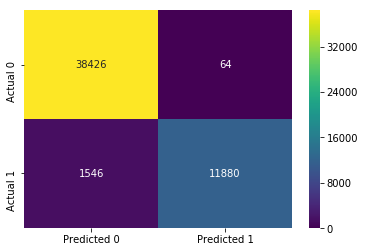

In [0]:
plot_confusion_matrix(y_train, y_pred);

In [0]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     38490
           1       0.99      0.88      0.94     13426

    accuracy                           0.97     51916
   macro avg       0.98      0.94      0.96     51916
weighted avg       0.97      0.97      0.97     51916



In [0]:
y_pred_proba = pipeline.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred_proba)

0.9979559791328676

The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections.

#### Column that is causing the Leakage = Risk

Risk category of facility: Each establishment is categorized as to its risk of adversely
affecting the public’s health, with 1 being the highest and 3 the lowest. The frequency of
inspection is tied to this risk, with risk 1 establishments inspected most frequently and
risk 3 least frequently. 

In [0]:
def rewrangle(X):
    X = X.copy()
    drop = 'Risk'
    X = X.drop(columns='Risk')
    return X

X_train = wrangle(train)
X_test = wrangle(test)

In [0]:
y_test = test.Fail

In [0]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[16:39:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.488663	validation_1-rmse:0.488517
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.479218	validation_1-rmse:0.479033
[2]	validation_0-rmse:0.471399	validation_1-rmse:0.471346
[3]	validation_0-rmse:0.46506	validation_1-rmse:0.464901
[4]	validation_0-rmse:0.459747	validation_1-rmse:0.459576
[5]	validation_0-rmse:0.455459	validation_1-rmse:0.455265
[6]	validation_0-rmse:0.451954	validation_1-rmse:0.451771
[7]	validation_0-rmse:0.449066	validation_1-rmse:0.4489
[8]	validation_0-rmse:0.446762	validation_1-rmse:0.446664
[9]	validation_0-rmse:0.444804	validation_1-rmse:0.444822
[10]	validation_0-rmse:0.443256	validation_1-rmse:0.443249
[11]	validation_0-rmse:0.441971	validation_1-rmse:0.442012
[12]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

model = XGBClassifier()
cross_val_score(model, X_train_encoded, y_train, 
                scoring='accuracy', cv=3, n_jobs=-1)

array([0.7426904 , 0.74134643, 0.74117307])

In [0]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='blue');

ValueError: ignored

In [0]:
!pip install eli5

     |████████████████████████████████| 102kB 5.0MB/s 


In [0]:
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)

[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_train_encoded, y_train)
feature_names = X_train_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0086 ± 0.0003,Address
0.0076 ± 0.0003,DBA Name
0.0076 ± 0.0002,Inspection Date
0.0011 ± 0.0003,Facility Type
0.0002 ± 0.0000,Latitude
0.0001 ± 0.0000,Risk
0.0000 ± 0.0000,City
0.0000 ± 0.0000,State
0.0000 ± 0.0000,Inspection Type
0 ± 0.0000,Longitude


In [0]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)
X_test = X_test[features]

Shape after removing features: (51916, 9)


In [0]:
X_test.columns

Index(['DBA Name', 'Facility Type', 'Risk', 'Address', 'City', 'State',
       'Inspection Date', 'Inspection Type', 'Latitude'],
      dtype='object')

In [0]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 1.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


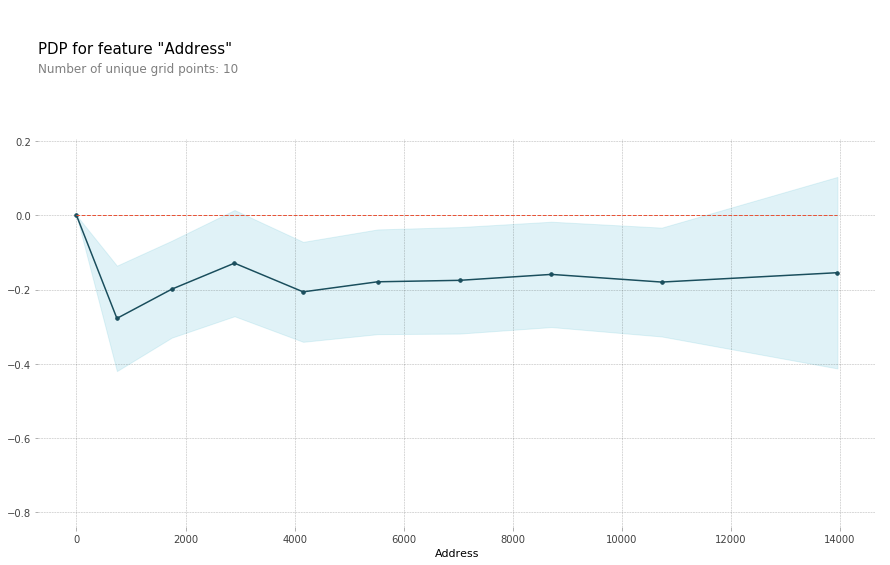

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Address'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

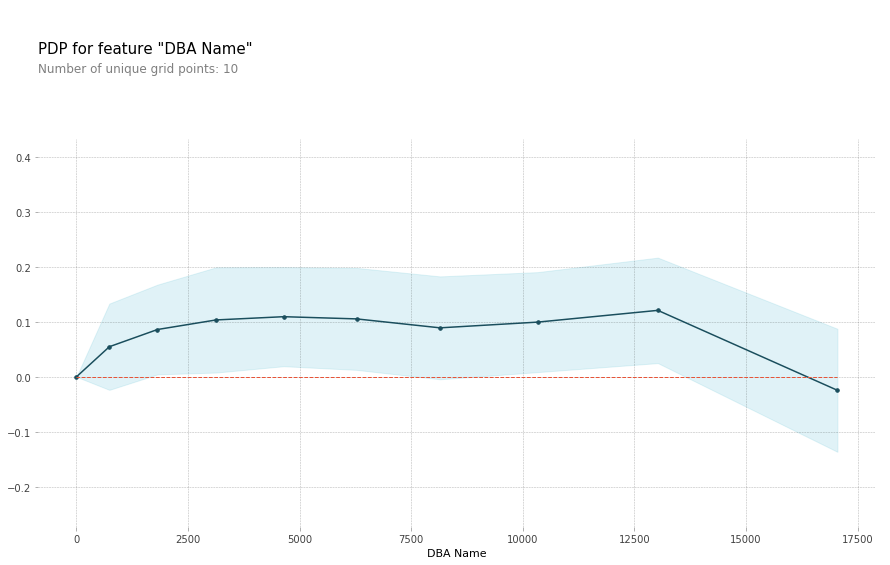

In [0]:
feature = 'DBA Name'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

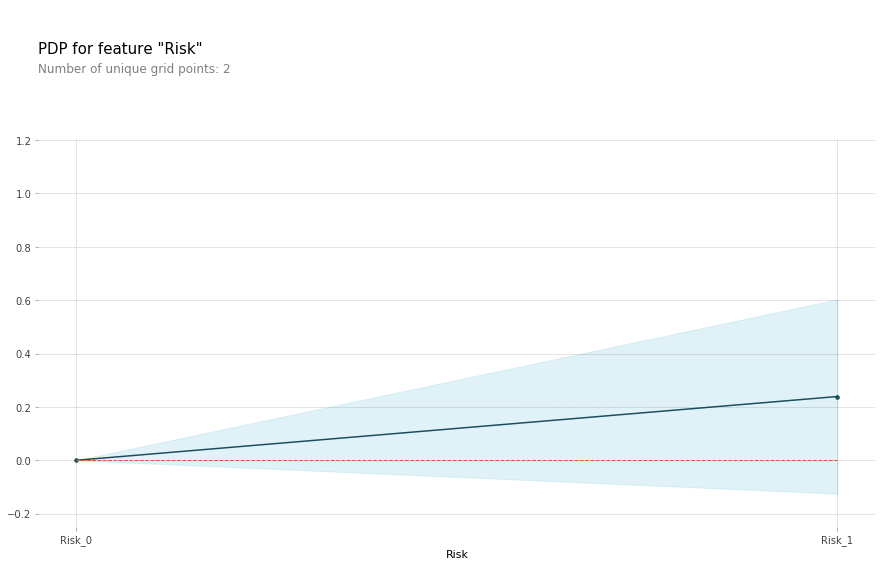

In [0]:
feature = 'Risk'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);


- What does Gradient Descent seek to minimize?
- Gradient descent seeks to minimize the output of a function.


- What is the "Learning Rate" and what is its function?
- The learning rate is the step size or amount that weights are updated throughout the training process of machine learning.
